[1 webinar](https://github.com/ranaroussi/futuresio-webinars/blob/master/01-prototyping-trading-strategies.ipynb
)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
# import mplfinance as mpf # https://github.com/matplotlib/mplfinance
from matplotlib import gridspec

# set default plotting size
import matplotlib.pylab
matplotlib.pylab.rcParams['figure.figsize'] = (12, 7)

# helper function for candlestick plotting
import matplotlib.dates as mdates
try:
    from mpf import candlestick_ohlc
except ImportError:
    #     from matplotlib.finance import candlestick_ohlc
    pass

def plot_candlestick(df, ax=None, fmt="%Y-%m-%d", cols=["open", "high", "low", "close"]):
    if ax is None:
        fig, ax = plt.subplots()
        
    idx_name = df.index.name
    dat = df.reset_index()[[idx_name]+cols]
    dat[df.index.name] = dat[df.index.name].map(mdates.date2num)
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter(fmt))
    plt.xticks(rotation=45)
    _ = candlestick_ohlc(ax, dat.values, width=.6, colorup='g', alpha =1)
    ax.set_xlabel(idx_name)
    ax.set_ylabel("Price")
    return ax

To recap:

1. we pull SPY data
2. Adjust 'close' for dividents and splits <- this makes figures way different from SPY
3. Calculate returns (day-on-day % change)
4. Adding smas
5. Calculating log returns and volatility (stdevs)
6. Introduce SIMPLE strategy. 
    * BUY on CLOSE if SPY <= -0.5%
    * SELL on CLOSE the next day.
    
    
7. Analyse strategy performance
    * Check overall Returns and Sharpe
    * Zoom in on interesting patterns

**Important NOTE to myself - be careful with %%!! 0.005 == 0.5%, not 5% !!!**

In [125]:
# https://github.com/ranaroussi/futuresio-webinars/blob/master/01-prototyping-trading-strategies.ipynb
t = yf.Ticker('SPY')
spy = t.history(start="2000-01-01", auto_adjust=True) # adjusted close takes away all splits/dividends
spy = spy.drop(['Dividends', 'Stock Splits'], axis=1)
spy.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,100.044041,100.044041,97.091645,98.146072,8164300
2000-01-04,96.859698,97.218203,94.234173,94.307983,8089800
2000-01-05,94.434507,95.510023,92.620893,94.476685,12177900
2000-01-06,94.223649,95.488962,92.958336,92.958336,6227200
2000-01-07,94.687580,98.356987,94.518871,98.356987,8066500


In [121]:
spy

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,100.044041,100.044041,97.091645,98.146072,8164300
2000-01-04,96.859698,97.218203,94.234173,94.307983,8089800
2000-01-05,94.434507,95.510023,92.620893,94.476685,12177900
2000-01-06,94.223649,95.488962,92.958336,92.958336,6227200
2000-01-07,94.687580,98.356987,94.518871,98.356987,8066500
...,...,...,...,...,...
2021-02-23,384.660004,388.950012,380.200012,387.500000,107284100
2021-02-24,386.329987,392.230011,385.269989,391.769989,72433900
2021-02-25,390.410004,391.880005,380.779999,382.329987,146670500


In [16]:
spy.to_csv('~/Desktop/trading/sp500.csv')

In [3]:
spy.shape

(5320, 5)

In [145]:
spy['Return'] = spy['Close'].pct_change()
returns = spy['Return']
returns.describe()

count    5322.000000
mean        0.000337
std         0.012518
min        -0.109424
25%        -0.004605
50%         0.000680
75%         0.005929
max         0.145198
Name: Return, dtype: float64

In [119]:
spy

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-03,100.044041,100.044041,97.091645,98.146072,8164300
2000-01-04,96.859698,97.218203,94.234173,94.307983,8089800
2000-01-05,94.434507,95.510023,92.620893,94.476685,12177900
2000-01-06,94.223649,95.488962,92.958336,92.958336,6227200
2000-01-07,94.687580,98.356987,94.518871,98.356987,8066500
...,...,...,...,...,...
2021-02-23,384.660004,388.950012,380.200012,387.500000,107284100
2021-02-24,386.329987,392.230011,385.269989,391.769989,72433900
2021-02-25,390.410004,391.880005,380.779999,382.329987,146670500


In [5]:
# how often it returned > 5% a day?
spy[returns > .005]['Return'].describe()

count    1524.000000
mean        0.012792
std         0.010083
min         0.005003
25%         0.006974
50%         0.009921
75%         0.014596
max         0.145198
Name: Return, dtype: float64

<AxesSubplot:xlabel='Date'>

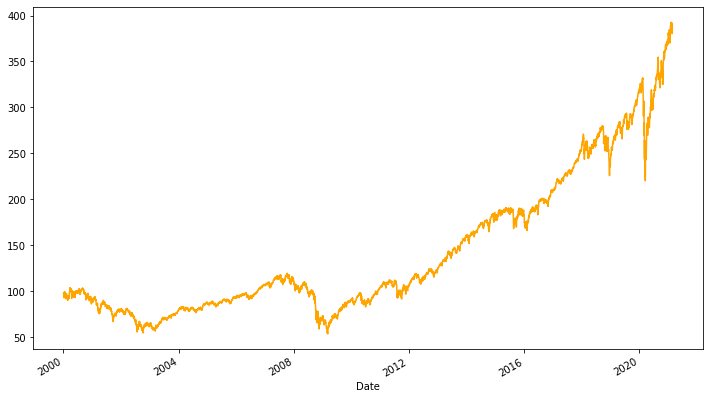

In [5]:
spy['Close'].plot(color='orange')

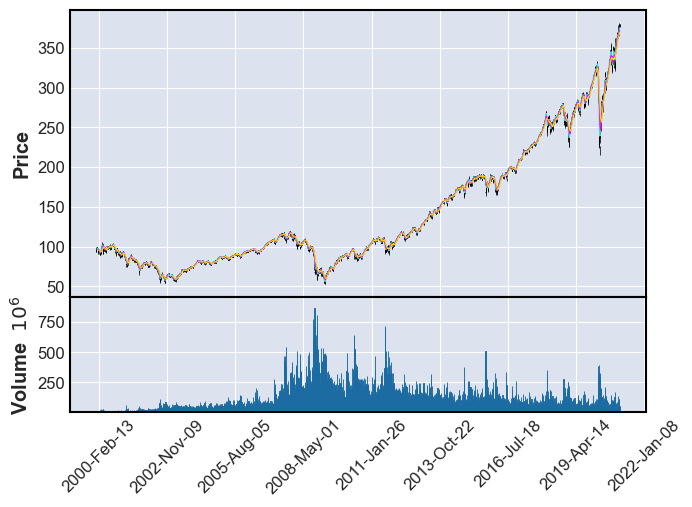

In [112]:
# type='ohlc' renko' 'line' 'candle' 'pnf'
# mav = moving averages
# https://github.com/matplotlib/mplfinance
mpf.plot(spy, type='ohlc', mav=(10, 20, 30), volume=True, show_nontrading=True)

<AxesSubplot:ylabel='Frequency'>

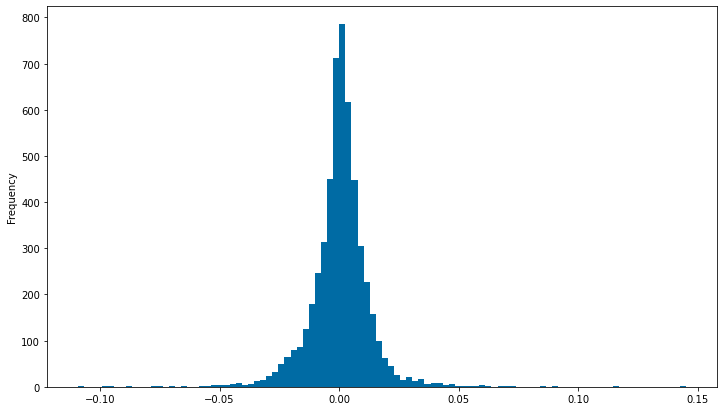

In [7]:
# https://matplotlib.org/3.3.3/tutorials/introductory/customizing.html
plt.style.use(
    'tableau-colorblind10'
)
ok = [
    'Solarize_Light2',
    'ggplot',
    'seaborn',
    'seaborn-colorblind',
    'seaborn-dark',
    'seaborn-dark-palette',
    'seaborn-darkgrid',
    'seaborn-deep',
    'seaborn-ticks',
    'seaborn-whitegrid',
    'tableau-colorblind10'
]
returns.plot.hist(bins=100)

In [159]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
returns.resample('A').sum() * 100

Date
2000-12-31    -6.429873
2001-12-31   -10.111412
2002-12-31   -20.833343
2003-12-31    26.199022
2004-12-31    10.784492
2005-12-31     5.246428
2006-12-31    15.209544
2007-12-31     6.277703
2008-12-31   -37.358537
2009-12-31    26.929428
2010-12-31    15.631107
2011-12-31     4.527769
2012-12-31    15.638894
2013-12-31    28.622718
2014-12-31    13.265251
2015-12-31     2.414633
2016-12-31    12.184700
2017-12-31    19.876699
2018-12-31    -3.231725
2019-12-31    27.969367
2020-12-31    22.469183
2021-12-31     1.327746
Freq: A-DEC, Name: Return, dtype: float64

<AxesSubplot:xlabel='Date'>

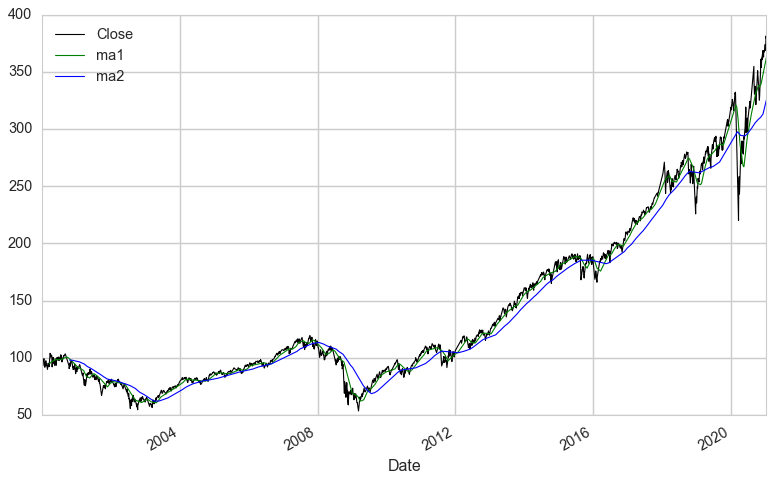

In [176]:
# sma 50 & 200
spy['ma1'] = spy['Close'].rolling(window=50).mean()
spy['ma2'] = spy['Close'].rolling(window=200).mean()
# spy.loc[~np.isnan(spy['ma1'])] # 5242 rows × 9 columns
spy[['Close', 'ma1', 'ma2']].plot(color=['black', 'green', 'blue'], linewidth=1)

Text(0, 0.5, 'stdevs')

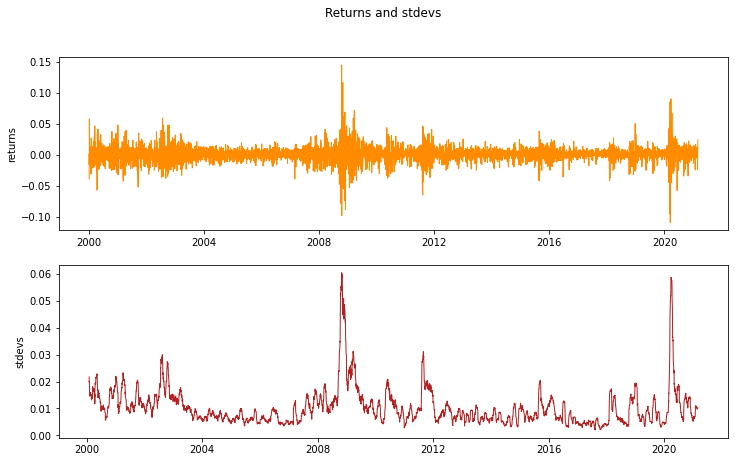

In [11]:
# rolling std
spy['Returns stdevs'] = stdevs = returns.rolling(window=20).std()
# spy['Returns ma20'].plot(linewidth=1, color='firebrick')

fig, axs = plt.subplots(2)
fig.suptitle('Returns and stdevs')
axs[0].plot(returns, linewidth=1, color='darkorange')
axs[1].plot(stdevs, linewidth=1, color='firebrick')

# styling
axs[0].set_ylabel('returns')
axs[1].set_ylabel('stdevs')

In [189]:
spy[['Return', 'Returns stdevs']].tail()

,Return,Returns stdevs
Date,,
2021-01-06,0.005979,0.006218
2021-01-07,0.014857,0.006958
2021-01-08,0.005698,0.006566
2021-01-11,-0.006741,0.006845
2021-01-12,0.000211,0.006819


In [191]:
spy['Return pct'] = spy['Return'] * 100
spy['Returns stdevs pct'] = spy['Returns stdevs'] * 100
spy[['Return pct', 'Returns stdevs pct']].describe()

,Return pct,Returns stdevs pct
count,5290.000000,5271.000000
mean,0.033386,1.040338
std,1.252926,0.710884
min,-10.942365,0.200985
25%,-0.463089,0.597437
50%,0.067804,0.862681
75%,0.592666,1.273297
max,14.519755,6.042227


**Market volatility**

[post](https://mathbabe.org/2011/07/24/measuring-historical-volatility/)


**Log returns** 

[post](https://mathbabe.org/2011/08/30/why-log-returns/)

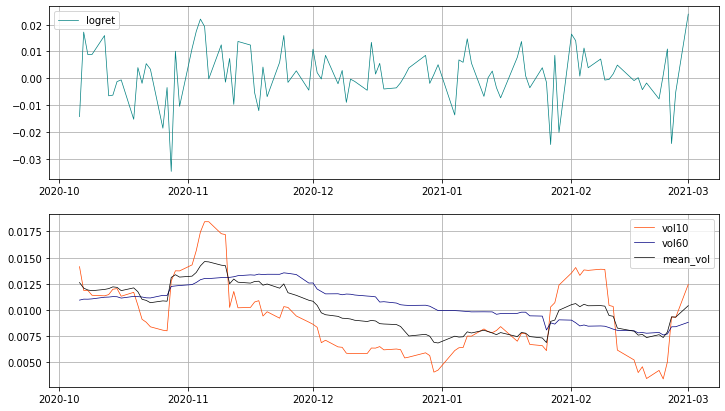

In [51]:
# calculating log returns 
spy['logret'] = logret = np.log(spy['Close'] / spy['Close'].shift(1))

# volatility estimate - 4 weeks
spy['volatility10'] = vol10 = logret.rolling(window=10).std()
spy['volatility20'] = vol20 = logret.rolling(window=20).std()
spy['volatility40'] = vol40 = logret.rolling(window=40).std()
spy['volatility60'] = vol60 = logret.rolling(window=60).std()

# wanna smooth 10 20 40 60 days volatility to see a representative line
mean_vol = spy.loc[:,['volatility10', 'volatility20', 'volatility40', 'volatility60']][-100:].transpose().mean()

# plot
fig, axs = plt.subplots(2)
axs[0].plot(logret[-100:], linewidth=.7, color='teal', label='logret')
axs[1].plot(vol10[-100:], linewidth=.7, color='orangered', label='vol10')
# axs[1].plot(vol20[-100:], linewidth=.7, color='orange', label='vol20')
# axs[1].plot(vol40[-100:], linewidth=.7, color='red', label='vol40')
axs[1].plot(vol60[-100:], linewidth=.7, color='navy', label='vol60')
axs[1].plot(mean_vol[-100:], linewidth=.7, color='black', label='mean_vol')

axs[0].grid(True)
axs[1].grid(True)
# axs[0].spines['top'].set_visible(False)
axs[0].legend()
axs[1].legend()


***Basic Strategy Example***

* BUY ON CLOSE when SPY drops 0.5% (or more)
* SELL ON CLOSE of next day

In [52]:
pf = pd.DataFrame({'spy': spy['Return']}).fillna(0)

In [5]:
pf.tail()

,spy
Date,
2021-02-17,0.000229
2021-02-18,-0.004256
2021-02-19,-0.001766
2021-02-22,-0.007692
2021-02-23,0.001214


In [53]:
# 2,1,0 days ago
pf['2_days_ago'] = pf['spy'].shift(2)  <= -0.005 
pf['yesterday'] = pf['spy'].shift(1)  <= -0.005 
pf['today'] = pf['spy']  <= -0.005 
pf.head(10)

,spy,2_days_ago,yesterday,today
Date,,,,
2000-01-03,0.000000,False,False,False
2000-01-04,-0.039106,False,False,True
2000-01-05,0.001789,False,True,False
2000-01-06,-0.016071,True,False,True
2000-01-07,0.058076,False,True,False
2000-01-10,0.003430,True,False,False
2000-01-11,-0.011966,False,False,True
2000-01-12,-0.009948,False,True,True
2000-01-13,0.013543,True,True,False


In [61]:
# pf['strategy'] = pf['yesterday']['spy'] WON'T WORK!! we need to broadcast
pf['strategy'] = pf[ pf['yesterday'] ]['spy'] 

# let's do -0.4%
pf['strategy4'] = pf[ pf['spy'].shift(1)  <= -0.004 ]['spy'] 

# let's do -0.6%
pf['strategy6'] = pf[ pf['spy'].shift(1)  <= -0.006 ]['spy'] 

**just scooping up returns from these days**

In [62]:
pf['strategy_ret'] = pf['strategy'].fillna(0).cumsum()
pf['spy_ret'] = pf['spy'].cumsum()

# -0.4%
pf['strategy4_ret'] = pf['strategy4'].fillna(0).cumsum()

# -0.6%
pf['strategy6_ret'] = pf['strategy6'].fillna(0).cumsum()

<AxesSubplot:xlabel='Date'>

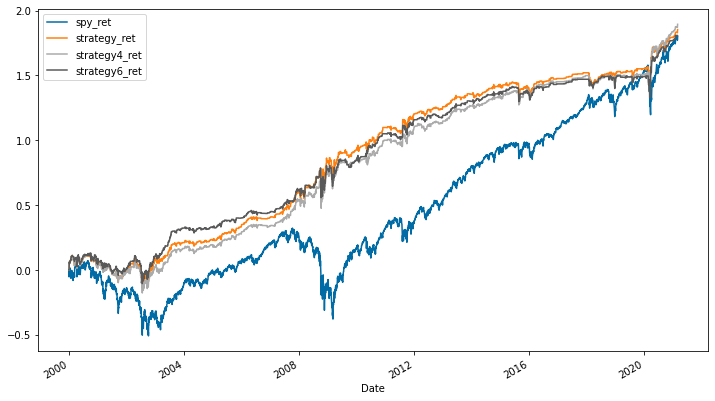

In [137]:
# WOW this really looks much worse in 2021 than in 2016!!
pf[['spy_ret', 'strategy_ret', 'strategy4_ret', 'strategy6_ret']].plot()

<AxesSubplot:xlabel='Date'>

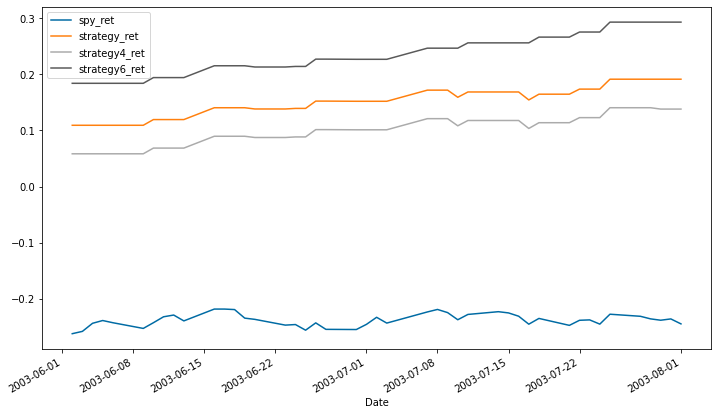

In [70]:
# anyways, the 0.5% strategy seems to beat SPY
pf.loc["2003-06-01":"2003-08-01", ['spy_ret','strategy_ret', 'strategy4_ret', 'strategy6_ret']].plot()

In [148]:
# Annualized Sharpe
def sharpe(returns, periods=252, riskfree=0):
    returns = returns.dropna()
    return np.sqrt(periods) * (np.mean(returns-riskfree)) / np.std(returns)

# Performance
def perf(bench, strat, annualize=False, riskfree=0):
    periods = len(bench) if annualize is False else 252
    return {
        'benchmark_return': bench.dropna(0).sum(),
        'strategy_return': strat.dropna(0).sum(),
        
        'benchmark_sharpe': sharpe(bench, periods, riskfree),
        'strategy_sharpe': sharpe(strat, periods, riskfree),
        
        'time_in_market': strat.count() / len(strat.index),
        "periods": periods
    }
     

On 25 July 2003 our strategy captured +1.7% 
We just happened to be long that day, because 24 July dropped -0.7%. 

In [138]:
pf.loc["2003-07-22":"2003-08-01", :]

,spy,2_days_ago,yesterday,today,strategy,strategy_ret,spy_ret,strategy4,strategy4_ret,strategy6,strategy6_ret,Open,Close
Date,,,,,,,,,,,,,
2003-07-22,0.009055,False,True,False,0.009055,0.173663,-0.238517,0.009055,0.122810,0.009055,0.275439,69.771297,70.110641
2003-07-23,0.000706,True,False,False,NaN,0.173663,-0.237811,NaN,0.122810,NaN,0.275439,70.138948,70.160156
2003-07-24,-0.007557,False,False,True,NaN,0.173663,-0.245368,NaN,0.122810,NaN,0.275439,70.690398,69.629936
2003-07-25,0.017666,False,True,False,0.017666,0.191329,-0.227702,0.017666,0.140476,0.017666,0.293105,69.750089,70.860039
2003-07-28,-0.003691,True,False,False,NaN,0.191329,-0.231393,NaN,0.140476,NaN,0.293105,70.959062,70.598503
2003-07-29,-0.004607,False,False,False,NaN,0.191329,-0.236000,NaN,0.140476,NaN,0.293105,70.796437,70.273277
2003-07-30,-0.002415,False,False,False,NaN,0.191329,-0.238414,-0.002415,0.138061,NaN,0.293105,70.414665,70.103600
2003-07-31,0.002319,False,False,False,NaN,0.191329,-0.236095,NaN,0.138061,NaN,0.293105,70.683315,70.266197
2003-08-01,-0.008854,False,False,True,NaN,0.191329,-0.244949,NaN,0.138061,NaN,0.293105,70.124778,69.644035


<AxesSubplot:xlabel='Date'>

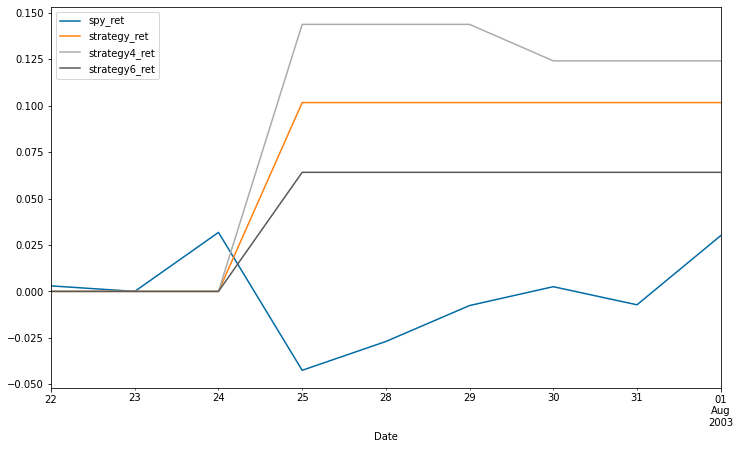

In [127]:
# wanna examine this 2 months, strategy did well here
# 'spy_ret' == 'spy'.cumsum()
x = pf.loc["2003-07-22":"2003-08-01", ['spy_ret','strategy_ret', 'strategy4_ret', 'strategy6_ret']]

# wanna see how much str4 gained
# restart at 2003-07-22
x = x/x.iloc[1] - 1

x.plot()

In [139]:
x

,spy_ret,strategy_ret,strategy4_ret,strategy6_ret
Date,,,,
2003-07-22,0.002970,0.000000,0.000000,0.000000
2003-07-23,0.000000,0.000000,0.000000,0.000000
2003-07-24,0.031779,0.000000,0.000000,0.000000
2003-07-25,-0.042509,0.101728,0.143851,0.064139
2003-07-28,-0.026988,0.101728,0.143851,0.064139
2003-07-29,-0.007617,0.101728,0.143851,0.064139
2003-07-30,0.002536,0.101728,0.124190,0.064139
2003-07-31,-0.007217,0.101728,0.124190,0.064139
2003-08-01,0.030016,0.101728,0.124190,0.064139


In [149]:
perf(x['spy_ret'], x['strategy4_ret'])

{'benchmark_return': -0.017031010634092847,
 'strategy_return': 0.8041230372280526,
 'benchmark_sharpe': -0.2527819849428472,
 'strategy_sharpe': 4.208810054440425,
 'time_in_market': 1.0,
 'periods': 9}

**Start strategy on a particular date**

In [187]:
def add_strategy(df, drop=-0.005):
    """
    Just want to test starting strategy on diff dates.
    """
    
    newdf = df.copy().fillna(0)
    
    prev_day = newdf['returns'].shift(1) <= drop
    newdf['strategy'] = newdf[ prev_day ]['returns']
    
    # are we in market now - we depend on strategy NaNs here
    newdf['is_in_mkt'] = newdf['strategy'].map(lambda x: not np.isnan(x))
    
    # Performance Measurement
    performance = perf(newdf['returns'], newdf['strategy'])
    
    # Add cumulative returns for plotting
    newdf['returns_cumsum'] = newdf['returns'].fillna(0).cumsum()
    newdf['strategy_cumsum'] = newdf['strategy'].fillna(0).cumsum()
    
    # clean up - remove strategy NaNs
    newdf['strategy'] = newdf['strategy'].fillna(0)
    
    return (newdf, performance)

In [188]:
pf2 = add_strategy(pd.DataFrame({'returns': spy['Return']}).loc["2003-07-01":"2003-08-01"])
pf2[1] 

# {'benchmark_return': 0.01004289988165108,
#  'strategy_return': 0.03935483272594087,
#  'benchmark_sharpe': 0.2169926537601462,
#  'strategy_sharpe': 2.1263168152244902,
#  'time_in_market': 0.30434782608695654,
#  'periods': 23}

{'benchmark_return': 0.01004289988165108,
 'strategy_return': 0.03935483272594087,
 'benchmark_sharpe': 0.2169926537601462,
 'strategy_sharpe': 2.1263168152244902,
 'time_in_market': 0.30434782608695654,
 'periods': 23}

In [169]:
pf2[0]

,returns,strategy,is_in_mkt,returns_cumsum,strategy_cumsum
Date,,,,,
2003-07-01,0.009218,NaN,False,0.009218,0.000000
2003-07-02,0.012584,NaN,False,0.021803,0.000000
2003-07-03,-0.010323,NaN,False,0.011480,0.000000
2003-07-07,0.019850,0.019850,True,0.031330,0.019850
2003-07-08,0.004468,NaN,False,0.035798,0.019850
2003-07-09,-0.005635,NaN,False,0.030163,0.019850
2003-07-10,-0.012726,-0.012726,True,0.017437,0.007124
2003-07-11,0.009466,0.009466,True,0.026903,0.016590
2003-07-14,0.004889,NaN,False,0.031791,0.016590


<AxesSubplot:xlabel='Date'>

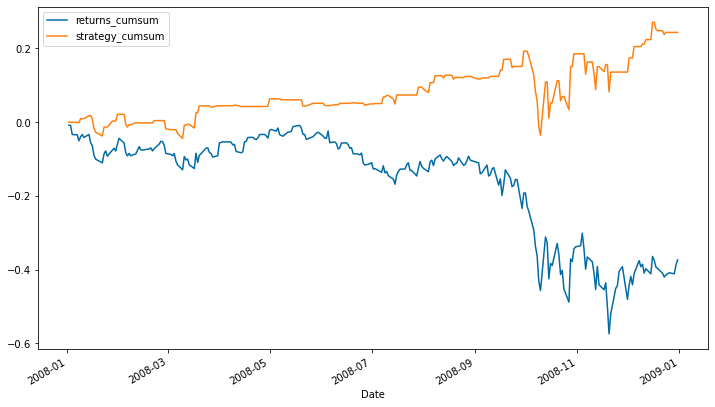

In [160]:
pf2[0].loc[:,['returns_cumsum', 'strategy_cumsum']].plot()

## Basic Performance Measuring

**Sharpe Ratio**

"reward-to-variability" ratio

the greater, the better.

![sharpe](https://wikimedia.org/api/rest_v1/media/math/render/svg/d54973db1901fd6f25c55d4bb88fddc75b0fe09f)


**Formula:**
Sharpe(x) = (rX - Rf) / stdev(x)

**Where:**
* X is the investment
* rX is the average rate of the return of X
* Rf is the best available risk-free security (i.e. T-bills)
* StdDev(X) is the standard deviation of rX

In [13]:
# Annualized Sharpe

def sharpe(returns, periods=252, riskfree=0):
    returns = returns.dropna()
    return np.sqrt(periods) * (np.mean(returns-riskfree)) / np.std(returns)

In [13]:
pf.head(10)


,spy,2_days_ago,yesterday,today,strategy,strategy_ret,spy_ret
Date,,,,,,,
2000-01-03,0.000000,False,False,False,NaN,0.000000,0.000000
2000-01-04,-0.039106,False,False,True,NaN,0.000000,-0.039106
2000-01-05,0.001789,False,True,False,0.001789,0.001789,-0.037317
2000-01-06,-0.016071,True,False,True,NaN,0.001789,-0.053388
2000-01-07,0.058076,False,True,False,0.058076,0.059865,0.004688
2000-01-10,0.003430,True,False,False,NaN,0.059865,0.008118
2000-01-11,-0.011966,False,False,True,NaN,0.059865,-0.003848
2000-01-12,-0.009948,False,True,True,-0.009948,0.049917,-0.013796
2000-01-13,0.013543,True,True,False,0.013543,0.063460,-0.000252


In [69]:
# EOY Returns

# resample date ranges into Annual 
eoy = pf.resample('A').sum()

# see difference in full percentage points of return
eoy['diff'] = eoy['strategy'] - eoy['spy']
print( np.round(eoy[['spy', 'strategy', 'diff']] * 100, 2) )

              spy  strategy   diff
Date                              
2000-12-31  -6.43      3.69  10.12
2001-12-31 -10.11     -5.20   4.91
2002-12-31 -20.83      9.04  29.88
2003-12-31  26.20     13.54 -12.66
2004-12-31  10.78      2.37  -8.41
2005-12-31   5.25      9.82   4.57
2006-12-31  15.21      7.22  -7.99
2007-12-31   6.28     19.61  13.33
2008-12-31 -37.36     23.44  60.80
2009-12-31  26.93      8.87 -18.05
2010-12-31  15.63     17.44   1.81
2011-12-31   4.53     10.44   5.91
2012-12-31  15.64      5.60 -10.04
2013-12-31  28.62      9.61 -19.01
2014-12-31  13.27      6.53  -6.74
2015-12-31   2.41     -2.61  -5.03
2016-12-31  12.18      8.18  -4.01
2017-12-31  19.88      4.47 -15.41
2018-12-31  -3.23     -3.73  -0.50
2019-12-31  27.97      6.98 -20.99
2020-12-31  22.47     23.96   1.49
2021-12-31   4.82      4.14  -0.68


In [18]:
# strategy would bring x1.8 per 1 usd over 20 years 
np.round(eoy['strategy'].cumsum() * 100, 2)

Date
2000-12-31      3.69
2001-12-31     -1.50
2002-12-31      7.54
2003-12-31     21.08
2004-12-31     23.45
2005-12-31     33.27
2006-12-31     40.50
2007-12-31     60.11
2008-12-31     83.55
2009-12-31     92.42
2010-12-31    109.86
2011-12-31    120.30
2012-12-31    125.90
2013-12-31    135.51
2014-12-31    142.04
2015-12-31    139.43
2016-12-31    147.61
2017-12-31    152.07
2018-12-31    148.34
2019-12-31    155.32
2020-12-31    179.28
2021-12-31    183.42
Freq: A-DEC, Name: strategy, dtype: float64

In [19]:
# spy would bring x1.7 per 1 usd over 20 years 
np.round(eoy['spy'].cumsum() * 100, 2)

Date
2000-12-31     -6.43
2001-12-31    -16.54
2002-12-31    -37.37
2003-12-31    -11.18
2004-12-31     -0.39
2005-12-31      4.86
2006-12-31     20.06
2007-12-31     26.34
2008-12-31    -11.02
2009-12-31     15.91
2010-12-31     31.54
2011-12-31     36.07
2012-12-31     51.71
2013-12-31     80.33
2014-12-31     93.60
2015-12-31     96.01
2016-12-31    108.20
2017-12-31    128.08
2018-12-31    124.84
2019-12-31    152.81
2020-12-31    175.28
2021-12-31    180.10
Freq: A-DEC, Name: spy, dtype: float64

**why has this strategy started to fail circa 2016?**

In [39]:
np.isnan(pf.loc["2000-01-05",'strategy'])

False

In [98]:
# mb spy didn't drop -.5% as often as before 2016 => theres less time_in_market

# days in the market - should we count working days only? we do hold assets over weekends tho
pf['dim'] = pf['strategy'].map(lambda x: not np.isnan(x))

# quarterly difference
avg = pf.resample('Q').sum() 
avg['diff'] = avg['strategy'] - avg['spy']
avg.loc['2010-01-01':'2015-01-01']

,spy,2_days_ago,yesterday,today,strategy,strategy_ret,spy_ret,tim,dim,diff
Date,,,,,,,,,,
2010-03-31,0.055282,12,12,11,0.035361,57.733429,10.419242,12,12,-0.019921
2010-06-30,-0.112847,22,23,24,0.034169,61.226540,11.889803,23,23,0.147016
2010-09-30,0.109935,15,14,13,0.032748,64.231971,10.668806,14,14,-0.077186
2010-12-31,0.103941,8,8,8,0.072093,68.482011,17.177179,8,8,-0.031848
2011-03-31,0.059393,11,11,11,-0.007411,68.120569,21.891180,11,11,-0.066804
2011-06-30,0.002182,16,16,16,-0.016368,68.268751,23.419178,16,16,-0.018550
2011-09-30,-0.134911,24,24,25,0.039776,70.970482,19.837125,24,24,0.174688
2011-12-31,0.118615,21,21,20,0.088398,73.297245,20.743662,21,21,-0.030216
2012-03-31,0.120686,5,5,5,0.021077,75.169363,26.948927,5,5,-0.099609


<AxesSubplot:ylabel='DAYS'>

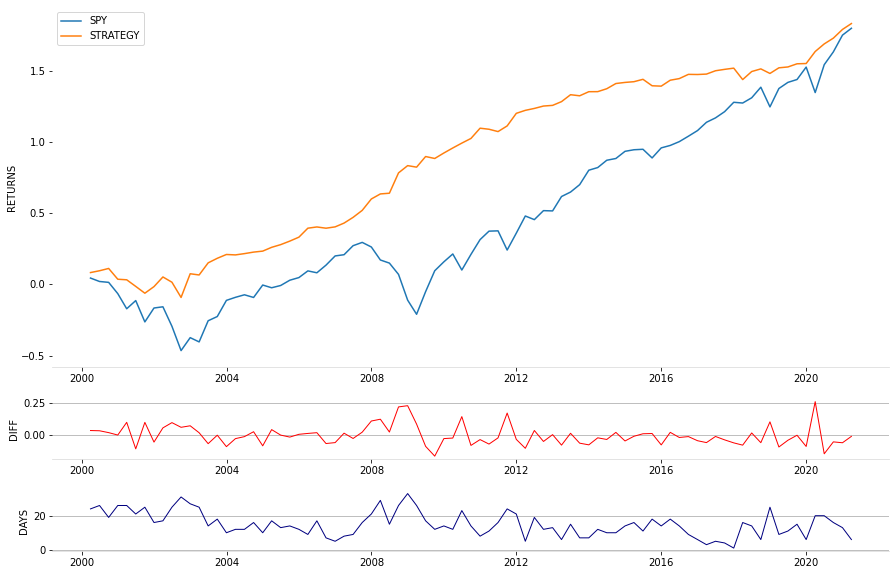

In [96]:
# plot
fig = plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(3, 1, height_ratios=[6,1,1])
ax0 = plt.subplot(gs[0])
ax0.set_ylabel('RETURNS')
plt.plot(avg['spy'].cumsum(), label='SPY')
plt.plot(avg['strategy'].cumsum(), label='STRATEGY')
plt.legend()

# difference
ax1 = plt.subplot(gs[1], sharex=ax0)
ax1.set_ylabel('DIFF')
ax1.plot(avg['diff'], color="red", linewidth=1)
ax1.grid(axis='y')
# ax1.axhline(200, color='r', linewidth=1.5)
# ax1.axhline(, color='g', linewidth=1.5)

# days in market
ax2 = plt.subplot(gs[2], sharex=ax0)
ax2.set_ylabel('DAYS')
ax2.plot(avg['dim'], color="navy", linewidth=1)
ax2.grid(axis='y')
# ax1.axhline(200, color='r', linewidth=1.5)
# ax1.axhline(, color='g', linewidth=1.5)

def rm_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    return ax

rm_spines(ax0)
rm_spines(ax1)
rm_spines(ax2)

### Example 2

* GO LONG where 50-day SMA > 200-day SMA (catching upward trend)
* GO SHORT where 50-day SMA < 200-day SMA (catching downward trend)